In [30]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
import wandb
from timm import create_model
from einops import rearrange, reduce
from sklearn.metrics import accuracy_score, f1_score
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness

In [3]:
torch.cuda.is_available()

True

## load datasets

In [4]:
def convert_rgb(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
        
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img)
        
    if torch.max(img)>1.1:
        img = TF.convert_image_dtype(img, dtype=torch.float32)
            
    return img

class RegionImgTransform(object):
    def __init__(self, p=.8, brightness=.1, contrast=.1, saturation=.1, hue=.1, sharpness=.3, normalize=True):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.sharpness = sharpness
        
        self.affine_transforms = Compose([
            RandomAffine(180),
            RandomResizedCrop((256, 256), scale=(.6, 1.)),
        ])
        
        if normalize:
            self.normalize = Normalize((0.219, 0.223, 0.250), (0.223, 0.227, 0.251)) # from HT397B1-H2 ffpe H&E image
        else:
            self.normalize = nn.Identity()
 
        self.p = p
    
    def apply_color_transforms(self, x, brightness, contrast, saturation, hue, sharpness):
        x = TF.adjust_brightness(x, brightness)
        x = TF.adjust_contrast(x, contrast)
        x = TF.adjust_saturation(x, saturation)
        x = TF.adjust_hue(x, hue)
        x = TF.adjust_sharpness(x, sharpness)
        return x
        
    def __call__(self, he, mask):
        """
        """
        if isinstance(he, torch.Tensor):
            hes = [he]
            masks = [mask]
            return_type = 'image'
        elif isinstance(he, dict):
            keys = list(he.keys())
            hes = [he[k] for k in keys]
            masks = [mask[k] for k in keys]
            return_type = 'dict'
        else:
            return_type = 'list'
                                
        # we apply transforms with probability p
        if torch.rand(size=(1,)) < self.p:
            brightness, contrast, saturation, hue, sharpness = (
                np.random.uniform(max(0, 1 - self.brightness), 1 + self.brightness, size=1)[0],
                np.random.uniform(max(0, 1 - self.contrast), 1 + self.contrast, size=1)[0],
                np.random.uniform(max(0, 1 - self.saturation), 1 + self.saturation, size=1)[0],
                np.random.uniform(-self.hue, self.hue, size=1)[0],
                np.random.uniform(max(0, 1 - self.sharpness), 1 + self.sharpness, size=1)[0],
            )
            # apply color jitter and sharpness
            hes = [self.apply_color_transforms(x, brightness, contrast, saturation, hue, sharpness)
                   for x in hes]
            xs = [torch.concat((rgb, m.unsqueeze(0)), dim=0) for rgb, m in zip(hes, masks)]
            xs = [self.affine_transforms(x) for x in xs]
            hes, masks = zip(*[(x[:-1], x[-1]) for x in xs])
        
        hes = [self.normalize(x) for x in hes]
                    
        if return_type == 'image':
            return hes[0], masks[0]
        elif return_type == 'dict':
            return {k:v for k, v in zip(keys, hes)}, {k:v for k, v in zip(keys, masks)}
        return hes, masks

In [6]:
class RegionDataset(Dataset):
    def __init__(self, region_to_cls_imgs, feat_df, y_col, transform=None, normalize_feats=True):
        self.region_to_cls_imgs = region_to_cls_imgs
        self.transform = transform
        self.idx_to_region = feat_df.index.to_list()
        
        
        self.X = torch.tensor(feat_df[[c for c in feat_df.columns if c != y_col]].values, dtype=torch.float32)
        
        ys = [val if not pd.isnull(val) else 'unknown' for val in feat_df[y_col]]
        self.idx_to_label = sorted(set(ys))

        self.label_to_idx = {l:i for i, l in enumerate(self.idx_to_label)}

        self.y = torch.nn.functional.one_hot(torch.tensor(
            [self.label_to_idx[l] for l in ys])).to(torch.float32)


    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        region_id = self.idx_to_region[idx]

        rgb = self.region_to_cls_imgs[region_id]['rgb']
        rgb = convert_rgb(rgb)
        mask = self.region_to_cls_imgs[region_id]['mask']
        mask = torch.tensor(mask).to(torch.float32)
        

        if self.transform:
            rgb, mask = self.transform(rgb, mask)

        return {
            'mask': mask.unsqueeze(0),
            'rgb': rgb,
            'y': self.y[idx],
            'X': self.X[idx]
        }

In [7]:
train_ds = torch.load('/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v1/data/train_ds.pt')
val_ds = torch.load('/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v1/data/val_ds.pt')
pred_ds = torch.load('/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v1/data/pred_ds.pt')

In [8]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=10)
pred_dl = DataLoader(pred_ds, batch_size=batch_size, num_workers=20)

In [9]:
d = train_ds[0]
d.keys()

dict_keys(['mask', 'rgb', 'y', 'X'])

In [10]:
d['rgb'].dtype, d['mask'].dtype, d['y'].shape, d['X'].shape

(torch.float32, torch.float32, torch.Size([3]), torch.Size([9]))

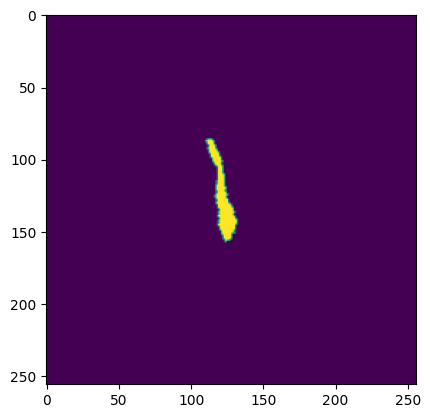

In [11]:
plt.imshow(d['mask'][0])

In [12]:
d['y']

tensor([0., 0., 1.])

In [13]:
d['X']

tensor([-1.3452, -0.1065,  2.1844,  1.3373,  2.9199,  0.9769,  3.5555,  0.1285,
         3.0484])

In [14]:
b = next(iter(train_dl))
b.keys()

dict_keys(['mask', 'rgb', 'y', 'X'])

In [15]:
b['rgb'].dtype, b['mask'].dtype

(torch.float32, torch.float32)

In [16]:
b = next(iter(pred_dl))
b.keys()

dict_keys(['mask', 'rgb', 'y', 'X'])

In [17]:
b['rgb'].shape, b['mask'].shape, b['y'].shape, b['X'].shape

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 1, 256, 256]),
 torch.Size([16, 4]),
 torch.Size([16, 9]))

## model

In [18]:
class RegionClassifier(nn.Module):
    def __init__(
            self,
            n_features,
            n_classes,
            backbone='resnet34',
    ):
        super().__init__()
        self.rgb_encoder = create_model(backbone, in_chans=3)
        self.mask_encoder = create_model(backbone, in_chans=1)
        
        self.encoded_downsample = nn.Linear(1000, n_features)
        
        self.tabular_encoder = nn.Sequential(
            nn.Linear(n_features, n_features),
            nn.BatchNorm1d(n_features),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(n_features, n_features),
            nn.BatchNorm1d(n_features),
            nn.ReLU(),
            nn.Dropout(.2),
        )
        
        self.head = nn.Sequential(
            nn.Linear(n_features, n_features),
            nn.BatchNorm1d(n_features),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(n_features, n_features),
            nn.BatchNorm1d(n_features),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(n_features, n_classes),
            nn.Softmax(dim=-1)
        )
        
        self.loss = nn.CrossEntropyLoss()   
        
    def calculate_loss(self, y_pred, y_true):
        return self.loss(y_pred, y_true)

    def forward(self, rgb, mask, feats):
        rgb_encoded = self.rgb_encoder(rgb)
        mask_encoded = self.mask_encoder(mask)
        encoded = rgb_encoded + mask_encoded
        encoded = self.encoded_downsample(encoded)
        
        tabular_encoded = self.tabular_encoder(feats)
        encoded += tabular_encoded
        
        probs = self.head(encoded)
        
        return probs


In [19]:
n_features, n_classes = b['X'].shape[1], b['y'].shape[1]
rgb, mask, feats = torch.rand(8, 3, 256, 256), torch.rand(8, 1, 256, 256), torch.rand(8, n_features)

model = RegionClassifier(n_features, n_classes)
out = model(rgb, mask, feats)
out.shape

torch.Size([8, 4])

In [20]:
model.calculate_loss(out, torch.rand(8, n_classes))

tensor(3.0831, grad_fn=<DivBackward1>)

In [21]:
out = model(b['rgb'], b['mask'], b['X'])
out.shape

torch.Size([16, 4])

In [46]:
class ModelLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super().__init__()
        
        self.model = model
        self.lr = lr
        
#         self.save_hyperparameters(ignore=['model'])
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        rgb, mask, y, X = batch['rgb'], batch['mask'], batch['y'], batch['X']
        probs = self.model(rgb, mask, X)
        loss = self.model.calculate_loss(probs, y)
        acc = accuracy_score(y.argmax(dim=-1).clone().detach().cpu().numpy(),
                             probs.argmax(dim=-1).clone().detach().cpu().numpy())
        f1 = f1_score(y.argmax(dim=-1).clone().detach().cpu().numpy(),
                      probs.argmax(dim=-1).clone().detach().cpu().numpy(), average='weighted')
        
        self.log_dict({'train/loss': loss, 'train/acc': acc, 'train/f1': f1},
                      on_step=False, on_epoch=True, prog_bar=True)
        
        
        result = {'loss': loss, 'probs': probs, 'y': y}
        return result
    
    def validation_step(self, batch, batch_idx):
        rgb, mask, y, X = batch['rgb'], batch['mask'], batch['y'], batch['X']
        probs = self.model(rgb, mask, X)
        loss = self.model.calculate_loss(probs, y)
        acc = accuracy_score(y.argmax(dim=-1).clone().detach().cpu().numpy(),
                             probs.argmax(dim=-1).clone().detach().cpu().numpy())
        f1 = f1_score(y.argmax(dim=-1).clone().detach().cpu().numpy(),
                      probs.argmax(dim=-1).clone().detach().cpu().numpy(), average='weighted')
        
        self.log_dict({'val/loss': loss, 'val/acc': acc, 'val/f1': f1},
                      on_step=False, on_epoch=True, prog_bar=True)
        
        
        result = {'loss': loss, 'probs': probs, 'y': y}
        return result
    
    def prediction_step(self, batch, batch_idx):
        rgb, mask, y, X = batch['rgb'], batch['mask'], batch['y'], batch['X']
        probs = self.model(rgb, mask, X)

        result = {'y_pred': probs.argmax(dim=-1), 'probs': probs, 'y_true': y}
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, batch):
        rgb, mask, y, X = batch['rgb'], batch['mask'], batch['y'], batch['X']
        return self.model(rgb, mask, X)

In [23]:
class LoggingCallback(pl.Callback):
    def __init__(self, log_every=10, log_n_samples=8):
        self.log_every = log_every
        self.log_n_samples = log_n_samples
    
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if trainer.current_epoch % self.log_every == 0 and batch_idx==0:
            img = batch['rgb'][:self.log_n_samples].clone().detach().cpu()
            img -= img.min()
            img /= img.max()
            logger.log_image(
                key=f"train/rgb",
                images=[i for i in img],
                caption=list(outputs['probs'][:self.log_n_samples].argmax(dim=-1).clone().detach().cpu().numpy())
            )
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        if trainer.current_epoch % self.log_every == 0 and batch_idx==0:
            img = batch['rgb'][:self.log_n_samples].clone().detach().cpu()
            img -= img.min()
            img /= img.max()
            logger.log_image(
                key=f"val/rgb",
                images=[i for i in img],
                caption=list(outputs['probs'][:self.log_n_samples].argmax(dim=-1).clone().detach().cpu().numpy())
            )


## training model

In [48]:
project = 'region_classifier'
log_dir = '/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v1/logs'

In [59]:
from pytorch_lightning.loggers import WandbLogger
logger = WandbLogger(project=project, save_dir=log_dir)

In [60]:
# wandb.finish()

In [61]:
config = {
    'n_classes': train_ds.y.shape[1],
    'n_features': train_ds.X.shape[1],
    'backbone': 'resnet34',
    'training': {
        'train_samples': len(train_ds),
        'val_samples': len(val_ds),
        'log_n_samples': 16,
        'max_epochs': 300,
        'check_val_every_n_epoch': 2,
        'log_every': 5,
        'accelerator': 'gpu',
        'devices': 1,
        'lr': 2e-4,
        'batch_size': batch_size,
        'precision': 32
    },
}
logger.experiment.config.update(config)

In [62]:
m = RegionClassifier(
    config['n_features'],
    config['n_classes'],
    backbone=config['backbone']
)
model = ModelLightning(m, lr=config['training']['lr'])

/data/estorrs/miniconda3/envs/mip/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [63]:
trainer = pl.Trainer(
    callbacks=[
        LoggingCallback(
            log_every=config['training']['log_every'],
            log_n_samples=config['training']['log_n_samples']
        ),
        ModelCheckpoint(
            dirpath="/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v1/ckpts",
            save_top_k=5, monitor="val/loss"
        )
    ],
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    check_val_every_n_epoch=config['training']['check_val_every_n_epoch'],
    enable_checkpointing=True,
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [64]:
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

/data/estorrs/miniconda3/envs/mip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v1/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type             | Params
-------------------------------------------
0 | model | RegionClassifier | 43.6 M
-------------------------------------------
43.6 M    Trainable params
0         Non-trainable params
43.6 M    Total params
174.394   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/data/estorrs/miniconda3/envs/mip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [65]:
cb = [c for c in trainer.callbacks if 'ModelCheckpoint' in str(type(c))][0]
cb.best_model_path

'/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v1/ckpts/epoch=277-step=7506.ckpt'

In [66]:
best = ModelLightning.load_from_checkpoint(cb.best_model_path)

/data/estorrs/miniconda3/envs/mip/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [67]:
result = trainer.predict(best, dataloaders=pred_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 27it [00:00, ?it/s]

In [68]:
probs = result[0]
for x in result[1:]:
    probs = torch.concat((probs, x), dim=0)
probs.shape

torch.Size([8299, 3])

In [69]:
df = pd.DataFrame(data=probs.detach().cpu().numpy(), columns=train_ds.idx_to_label, index=pred_ds.idx_to_region)
df.index.name = 'region_id'
df

,dcis,idc,normal
region_id,,,
HT397B1-H3A1_516,0.000235,0.000154,0.999610
HT206B1-H1_85,0.000054,0.999938,0.000008
HT323B1-H1A4_1341,0.008480,0.988422,0.003098
HT323B1-H1A4_938,0.000278,0.000183,0.999539
HT323B1-H1A1_803,0.050103,0.935101,0.014795
...,...,...,...
HT206B1_H1_06252022_317,0.001995,0.997492,0.000512
HT323B1-H1A1_1781,0.003362,0.995732,0.000905
HT323B1-H1A1_1585,0.052838,0.041085,0.906077


In [70]:
df.to_csv('/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v1/results/probs.txt', sep='\t')